In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin
from math import pi
L_ = 2.
P_ = 6000.0

h_ = 0.1
b_ = 0.1
E_ = 200000000000.0
a_ = 0.6
Q = 1000


def M(x):
    if x < a_:
        return P_ * x
    elif (x >= a_) and (x < L_-a_):
        return P_ * a_
    else:
        return P_ * (L_ - x)

def f(x):
    return 12 * M(x) / (E_ * b_ * h_**3)

def u_actual(x):
    # Вычисляем beta = 12 * P / (E * b * h^3)
    beta = 12 * P_ / (E_ * b_ * h_**3)
    
    # Константы интегрирования в аналитических выражениях
    C1 = - (beta * a_ / 2) * (L_ - a_)
    C2 = - (beta * a_ * L_) / 2
    C3 = - (beta / 2) * (L_**2 - L_ * a_ + a_**2)
    D2 = (beta * a_**3) / 6
    D3 = (beta * L_ / 6) * (L_**2 - 3 * L_ * a_ + 3 * a_**2)
    
    if 0 <= x < a_:
        return (beta / 6) * x**3 + C1 * x
    elif a_ <= x < L_ - a_:
        return (beta * a_ / 2) * x**2 + C2 * x + D2
    elif L_ - a_ <= x <= L_:
        return beta * ( (L_ / 2) * x**2 - x**3 / 6 ) + C3 * x + D3
    else:
        raise ValueError("x должно быть в интервале [0, L]")

def find_node(x, x_nodes):
    for i in range(1, len(x_nodes)):
        if x < x_nodes[i]:
            return i-1
    return len(x_nodes)-2

def solve(N):
    x_nodes = np.linspace(0, L_, N+1)
    Le = x_nodes[1] - x_nodes[0]

    K = np.zeros((N+1, N+1))
    for i in range(N):
        K[i][i:i+2] += [1, -1]
        K[i+1][i:i+2] += [-1, 1]

    K /= Le
    K[0][1], K[-1][-2] = 0, 0
    K[0][0], K[-1][-1] = 1, 1
    P = np.zeros((N+1, N+1))
    for i in range(N):
        P[i][i:i+2] += [2, 1]
        P[i+1][i:i+2] += [1, 2]

    P *= -Le / 6
    P[0][0:2] = [0, 0]
    P[-1][-2:] = [0, 0]

    P = np.dot(P, [f(interval) for interval in x_nodes])

    u_coeffs = np.linalg.solve(K, P)

    return x_nodes, u_coeffs, K

def approx(x, x_nodes, u_coeffs):
    dx = x_nodes[1] - x_nodes[0]
    output = np.zeros(len(x))
    for i in range(len(x)):
        k = find_node(x[i], x_nodes)
        a0 = (u_coeffs[k] * x_nodes[k+1] - u_coeffs[k+1] * x_nodes[k])/dx
        a1 = (u_coeffs[k] - u_coeffs[k+1])/-dx
        output[i] = a0 + a1*x[i] #(7)
    return output


def relative_errors(x_nodes, u_coeffs):
    x = np.linspace(0, L_, Q)
    u_h = np.array(approx(x, x_nodes, u_coeffs))
    u_ex = np.array([u_actual(i) for i in x])

    up_max = np.max(np.abs(u_ex - u_h))
    low_max = np.max(np.abs(u_ex))
    Er = up_max / low_max

    dx = x[1] - x[0]
    up_sum = np.sum((u_ex - u_h)**2*dx)
    low_sum = np.sum(u_ex**2*dx)
    ErL2 = np.sqrt(up_sum/low_sum)

    return Er, ErL2

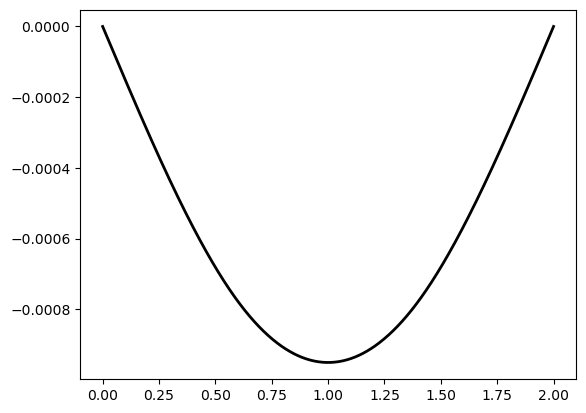

In [11]:
# Аналитическое решение
x = np.linspace(0, L_, Q)
u = [u_actual(i) for i in x]
plt.plot(x, u, label='Analytical solution', color='black', linewidth=2)
plt.show()

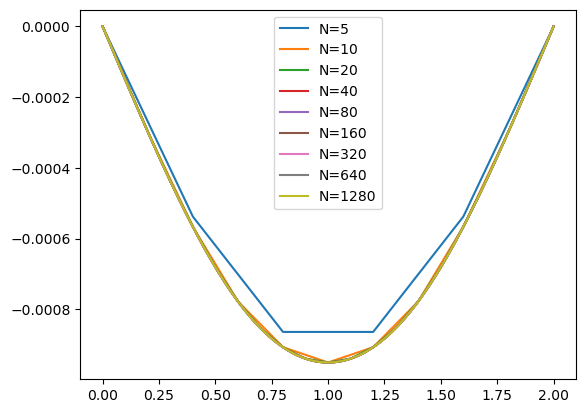

,N,Er,order,ErL2,cond_K,time
0,5,9.09e-02,3.63,8.10e-02,1.78e+01,0.001
1,10,1.14e-02,3.17,8.99e-03,5.85e+01,0.000
2,20,2.84e-03,2.00,2.26e-03,2.00e+02,0.000
3,40,7.10e-04,2.00,5.64e-04,7.27e+02,0.000
4,80,1.78e-04,2.00,1.41e-04,2.75e+03,0.001
5,160,4.44e-05,2.00,3.53e-05,1.07e+04,0.001
6,320,1.11e-05,2.00,8.82e-06,4.21e+04,0.003
7,640,2.77e-06,2.00,2.20e-06,1.67e+05,0.012
8,1280,6.93e-07,2.00,5.51e-07,6.67e+05,0.049


In [14]:
import pandas as pd
import time

x = np.linspace(0, L_, Q)
plt.plot(x, [u_actual(i) for i in x], 'r')
prevErL2=1
logs = []
for N in [5, 10, 20, 40, 80, 160, 320, 640, 1280]:
    start = time.time()
    x_nodes, u_coeffs, K = solve(N)
    end = time.time()
    time_taken = end - start
    Er, ErL2 = relative_errors(x_nodes, u_coeffs)
    plt.plot(x, approx(x, x_nodes, u_coeffs), label=f'N={N}')
    logs.append({'N': N,
                 'Er': f'{Er:.2e}',
                 'order': f'{np.log2(prevErL2/ErL2):.2f}',
                 'ErL2': f'{ErL2:.2e}',
                 'cond_K': f'{np.linalg.cond(K):.2e}',
                 'time': f'{time_taken:.3f}'})

    prevErL2 = ErL2

plt.legend()
plt.show()

df = pd.DataFrame(logs)
df

In [15]:
df.to_excel('task3_results.xlsx', index=False)